# AWS MWTA

## Intro
* **Date**: 1/2/2021
* **What**: I'm basically just doing the same experiment as before ... except I'm running on AWS baby!!  Also I just realized I don't have auto-corrected installed on this version of jupyter.  Yikes.  Might need to do that soon.
* **Why**: Because I want to see what the P3.2x can do with its beefy GPU and everything.
* **Hopes**: I'm hoping CuPy works, and training goes *really* fast.  That'd be dope.
* **Limitations**: I'm not sure how effective CuPy is at moving stuff between CPU and GPU, so I'm nervous that the calculations won't be as fast.  I guess the only way to see is to see.

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from time import time

In [4]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

m_flat_tr = train_x.reshape(train_x.shape[0], -1) / 255.0
m_flat_te = test_x.reshape(test_x.shape[0], -1) / 255.0 

m_tr_len, m_len = m_flat_tr.shape

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val, vmin=0)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

11493376/11490434 [==============================] - 4s 0us/step


In [5]:
m_noise = np.clip(m_flat_tr + np.random.normal(0, 0.2, m_flat_tr.shape), 0, 1)
gp_noise = cp.asarray(m_noise)

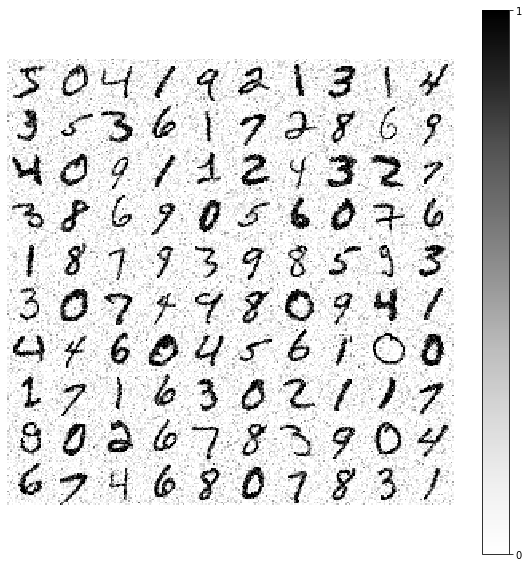

In [6]:
fig = plt.figure(figsize=(10, 10))

draw_weights(m_noise, 10, 10, 28, fig)

In [7]:
def reconstruct(img_i, w, Kx, Ky, gp, vmax, vmin):
    s_len = 28

    img = gp[img_i]

    v = img.reshape(-1, 1)
    p = w @ v
    winners = cp.argsort(p, axis=0)[-n_w:]
    mask = cp.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o.reshape(Ky, Kx).get(), cmap="Greys")

    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(r.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)

    plt.show()

## Analysis Dialog

Ok, here we go!  Here's to hoping this goes super fast!

In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 10
Ky = 10
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 1, (N, m_len))
xi = 0.002

for ep in range(Nep):
    inputs = gp_noise[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>

100%|██████████| 6000/6000 [00:03<00:00, 1954.86it/s]


Ok, well, that's doing more cycles per second than my computer.  Let's do 400 next.  And, praise the lord, tqdm is making small bars!  Huge fan of that.  What we be the dopest sauce is if when I keyboard interrupt, tqdm doesn't literally have a conniption.  Aight, let's do this!

<IPython.core.display.Javascript object>


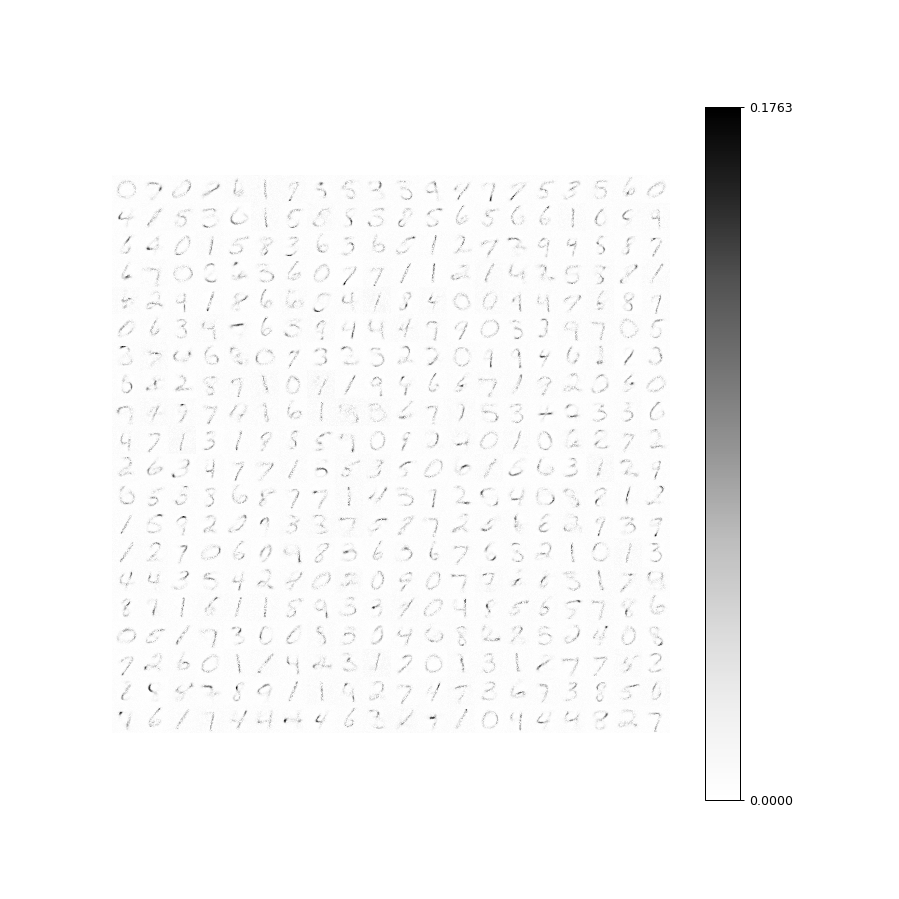

100%|██████████| 6000/6000 [00:02<00:00, 2100.72it/s]


In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 20
Ky = 20
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 1, (N, m_len))
xi = 0.002

for ep in range(Nep):
    inputs = gp_noise[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

Oh my fucking gosh, it literally is going *faster* than with 100 neurons!!  900 neurons, here we come!

<IPython.core.display.Javascript object>


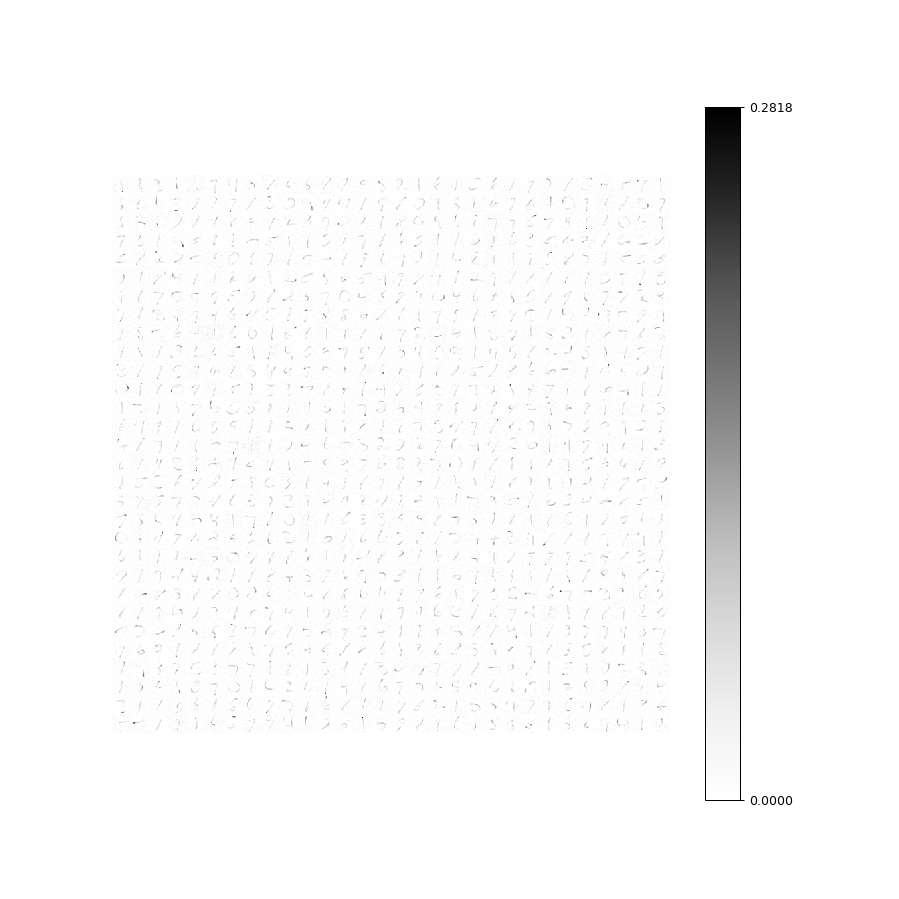

100%|██████████| 6000/6000 [00:03<00:00, 1933.14it/s]


In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 30
Ky = 30
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 0.1, (N, m_len))
xi = 0.05

for ep in range(Nep):
    inputs = gp_noise[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

...I think I'm literally in love.  The only thing to do is to keep pushing it.  This is unreal.  Also I'm listening to the interstellar soundtrack right now, and it's perfect for the emotion of deep bliss I'm feeling at the moment.

In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 100
Ky = 100
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 0.1, (N, m_len))
xi = 0.05

for ep in range(Nep):
    inputs = gp_noise[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>

100%|██████████| 6000/6000 [00:08<00:00, 729.65it/s]


This is literally *insanity!!!!* I'm sooooooo frikin happy!!!!!!!  I'm going to do reconstructions on this, see how we're looking, then I'm going to see how long 400,000 neurons takes.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


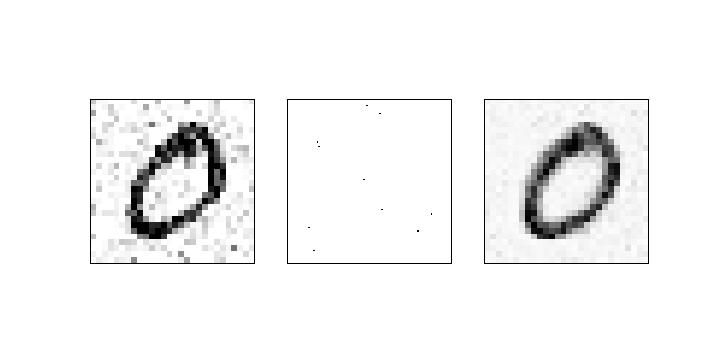

<IPython.core.display.Javascript object>


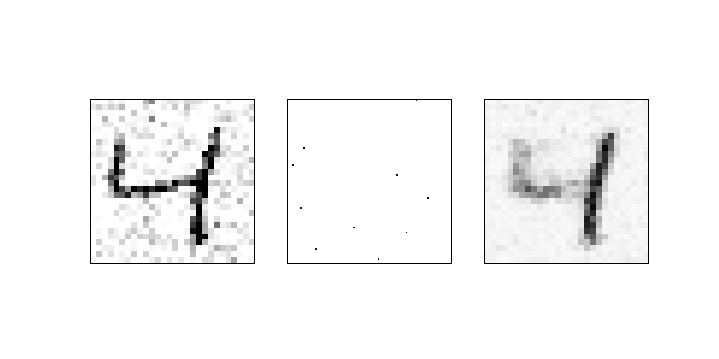

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


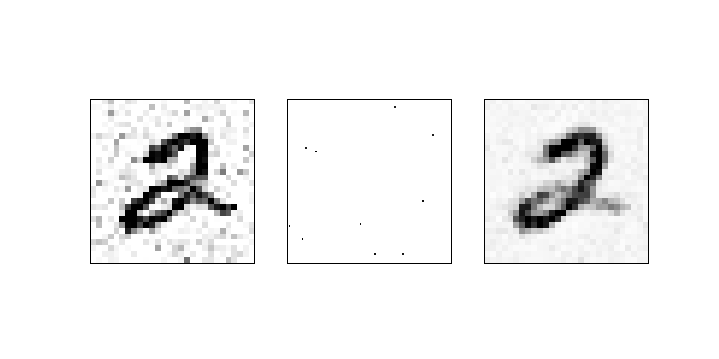

<IPython.core.display.Javascript object>


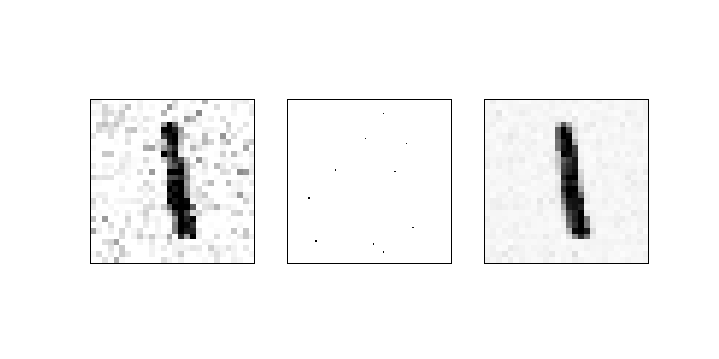

<IPython.core.display.Javascript object>


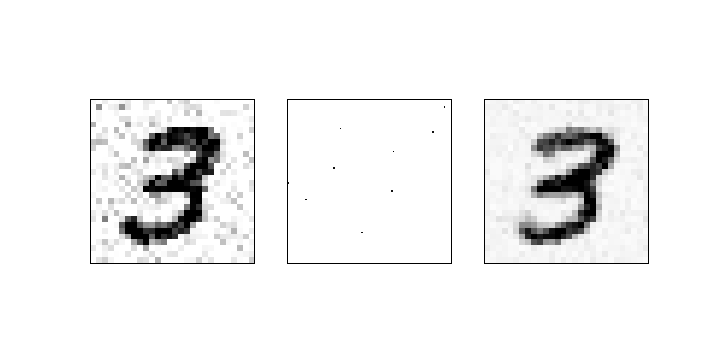

<IPython.core.display.Javascript object>


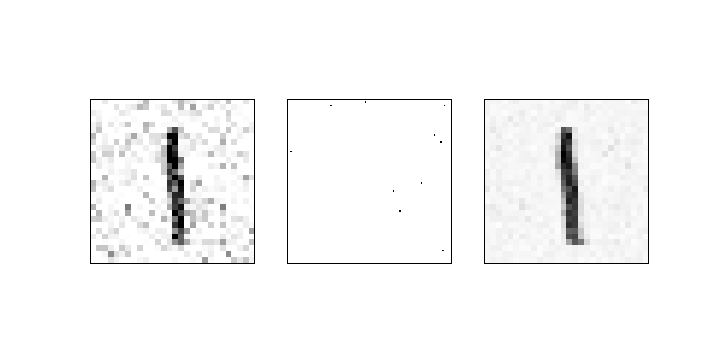

<IPython.core.display.Javascript object>


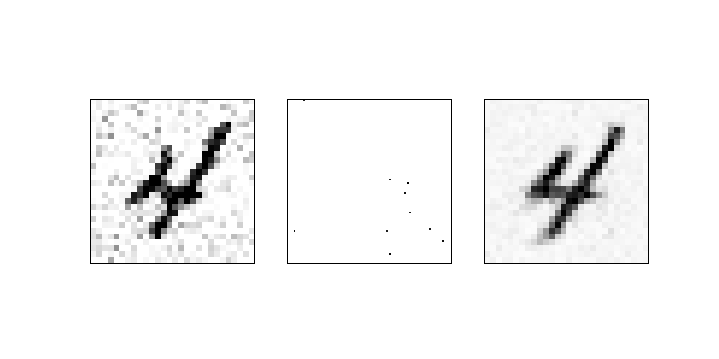

In [13]:
offset = 0

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise, 1, 0)

Actually, I'm going to try this again, but with a higher learning constant.  Because, ya know, this is literally more neurons than there are inputs.

<IPython.core.display.Javascript object>


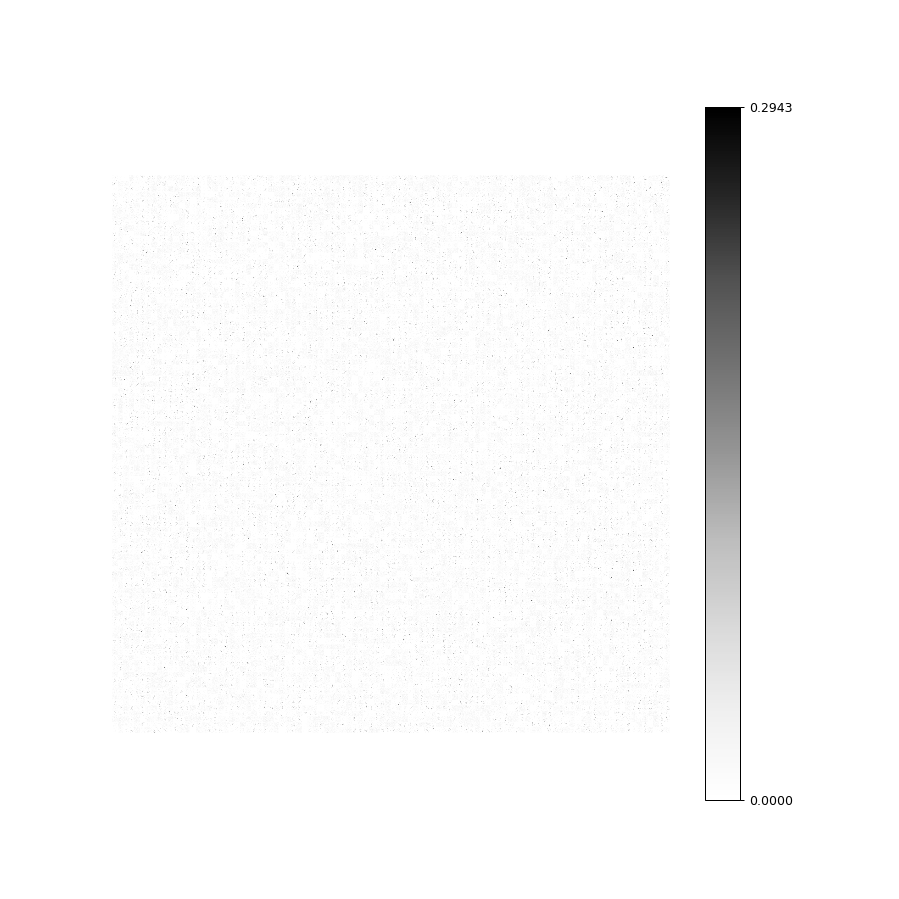

100%|██████████| 6000/6000 [00:08<00:00, 729.28it/s]


In [14]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 100
Ky = 100
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 0.1, (N, m_len))
xi = 0.1

for ep in range(Nep):
    inputs = gp_noise[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


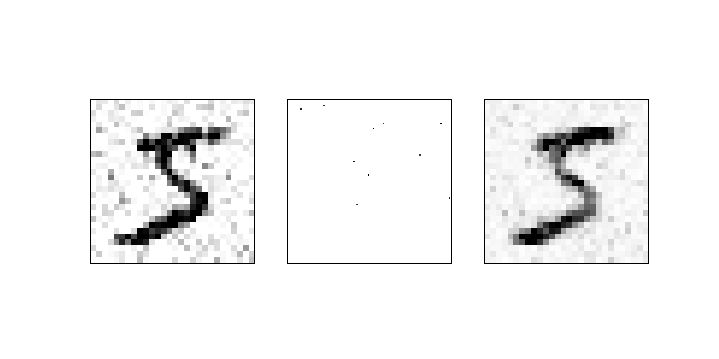

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


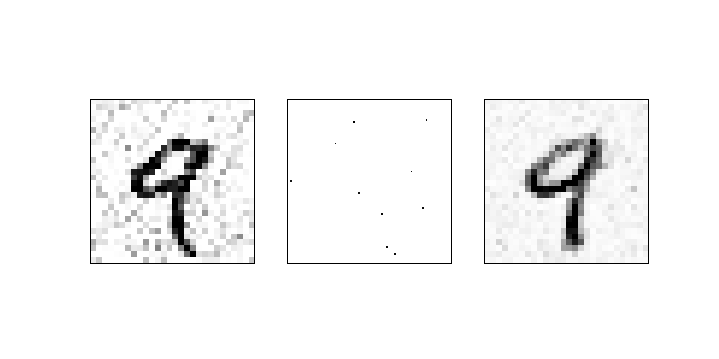

<IPython.core.display.Javascript object>


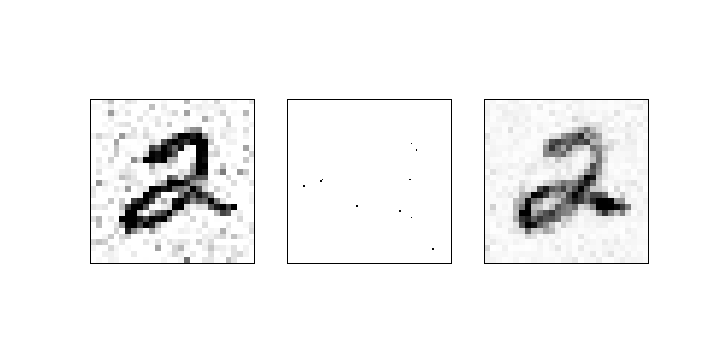

<IPython.core.display.Javascript object>


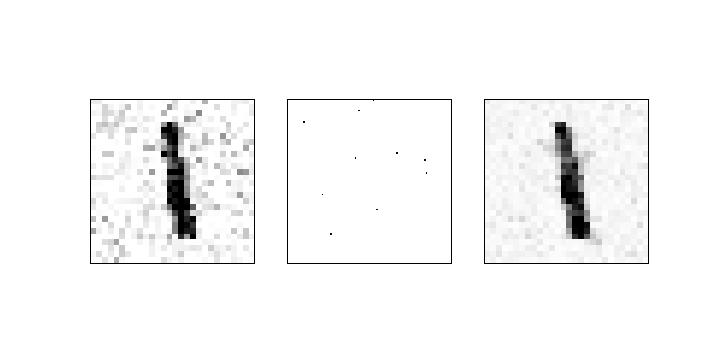

<IPython.core.display.Javascript object>


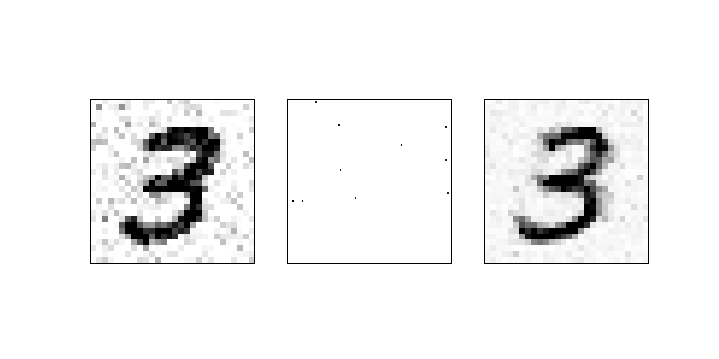

<IPython.core.display.Javascript object>


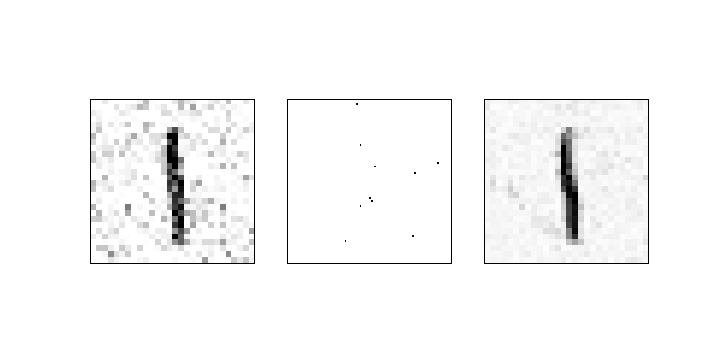

<IPython.core.display.Javascript object>


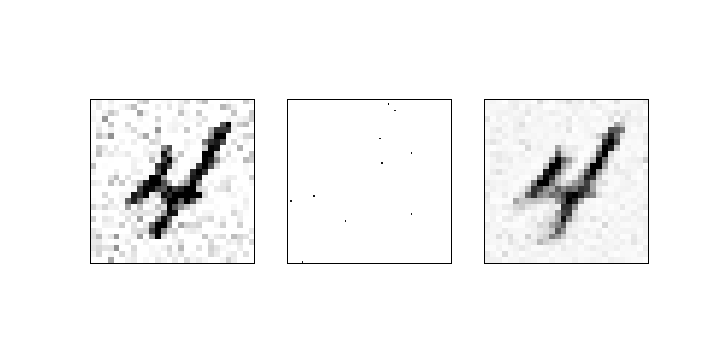

In [15]:
offset = 0

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise, 1, 0)

I honestly think I'm getting more noise simply because the learning constant is so high.  I'm going to lower the learning constant back down to 0.01, and then train on 2 epochs.

<IPython.core.display.Javascript object>


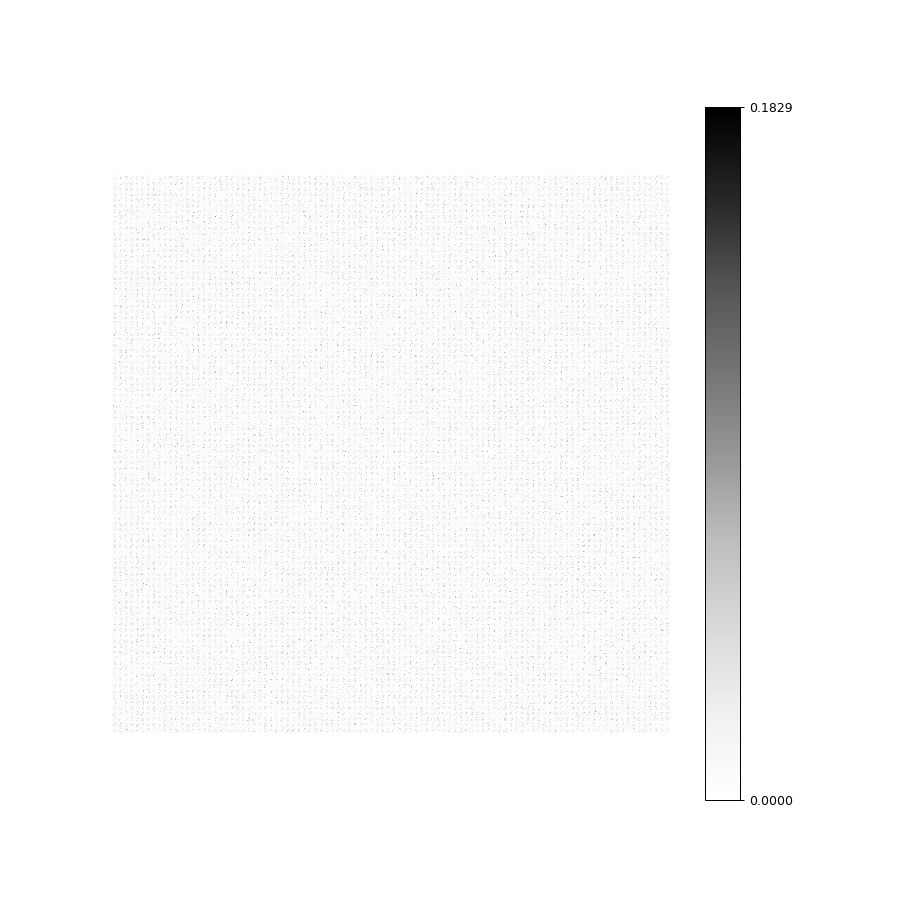

100%|██████████| 12000/12000 [00:16<00:00, 723.14it/s]


In [16]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 12000

Kx = 100
Ky = 100
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 0.1, (N, m_len))
xi = 0.01

for ep in range(Nep):
    inputs = gp_noise[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


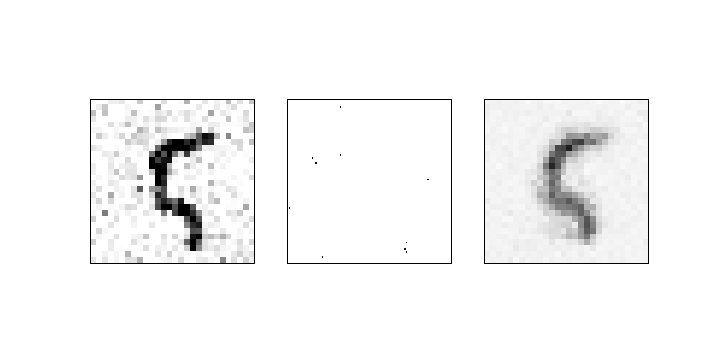

<IPython.core.display.Javascript object>


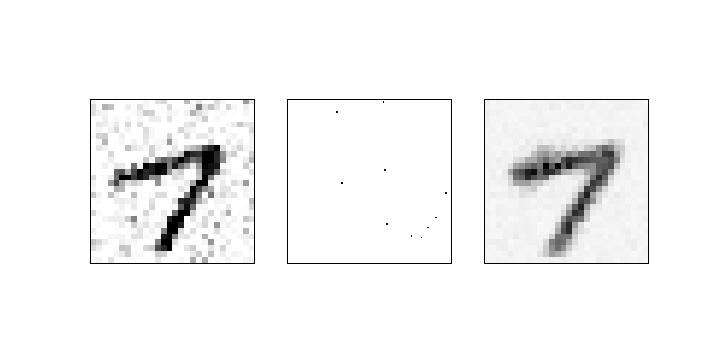

<IPython.core.display.Javascript object>


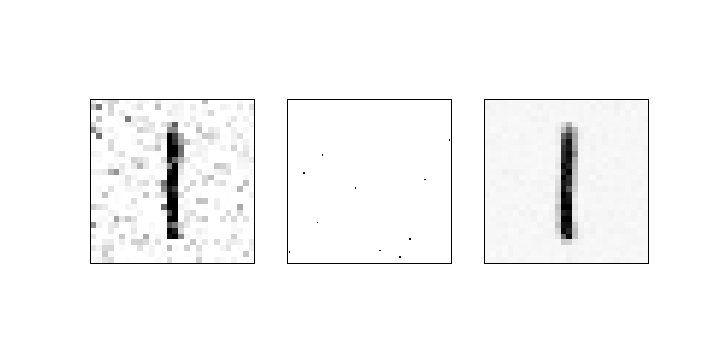

<IPython.core.display.Javascript object>


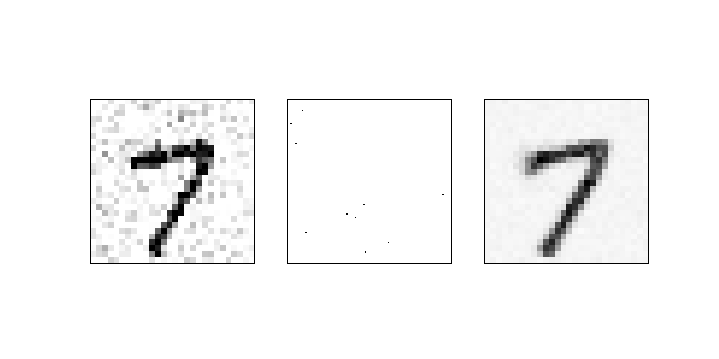

<IPython.core.display.Javascript object>


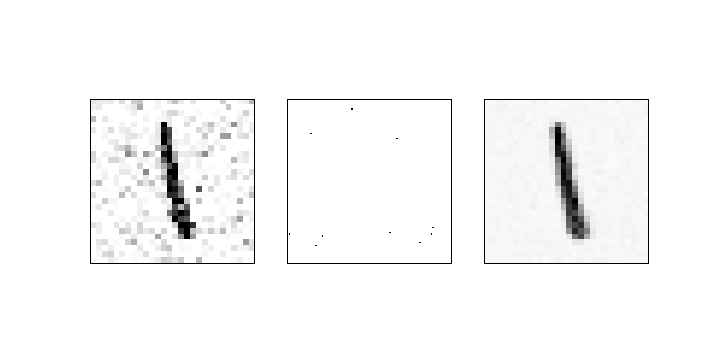

<IPython.core.display.Javascript object>


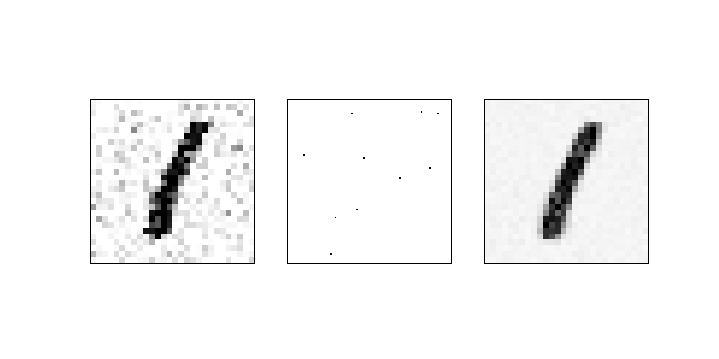

<IPython.core.display.Javascript object>


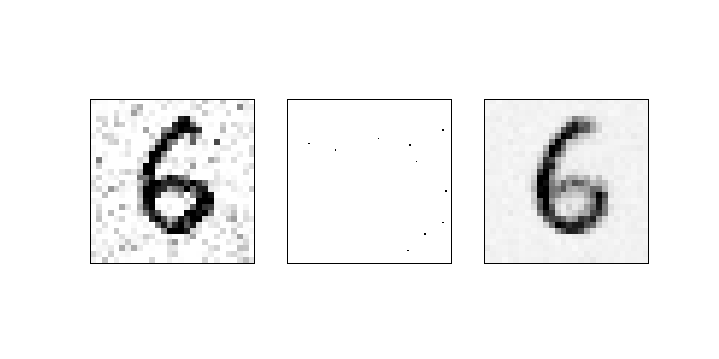

<IPython.core.display.Javascript object>


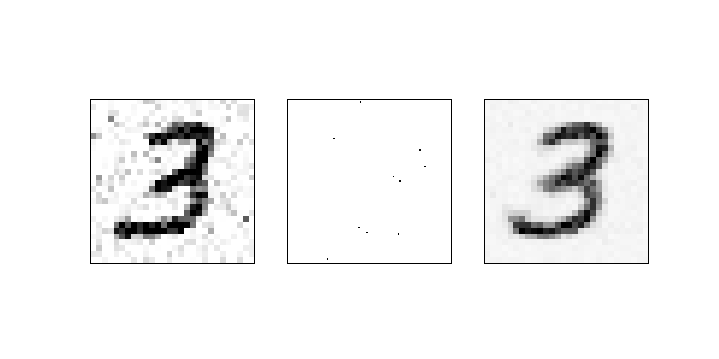

<IPython.core.display.Javascript object>


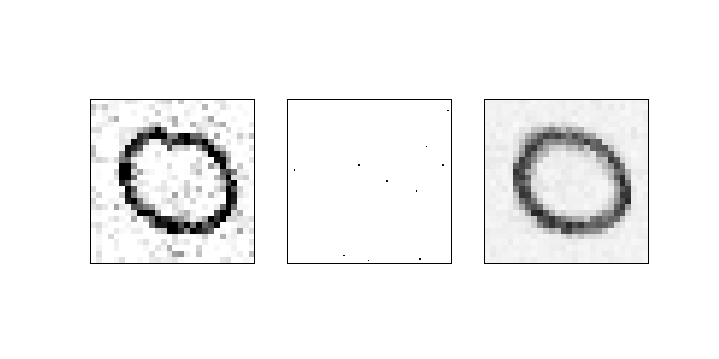

<IPython.core.display.Javascript object>


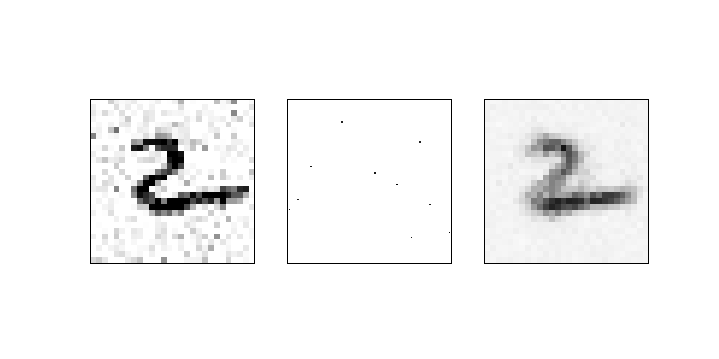

In [18]:
offset = 100

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise, 1, 0)

Holy snoots that's good.  I suppose you'd certainly expect it to be that good, given it's literally 100,000 neurons, but still, this is actually amazing.  I'm going to run this with 400,000 neurons, and then try different noise signatures.

<IPython.core.display.Javascript object>


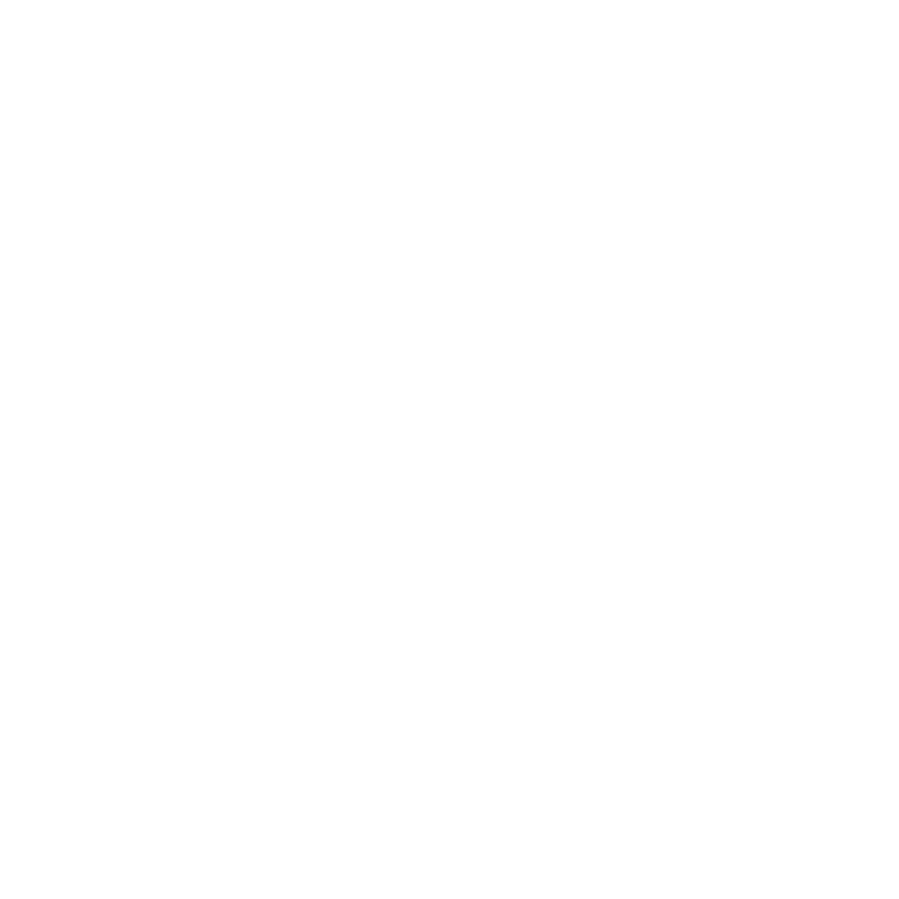

 19%|█▊        | 2231/12000 [00:09<00:43, 226.30it/s]


KeyboardInterrupt: 

In [19]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 12000

Kx = 200
Ky = 200
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 0.1, (N, m_len))
xi = 0.1

for ep in range(Nep):
    inputs = gp_noise[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

Yeah, ok, I found the limit.  Oh, and I meant to say that this is 10,000 neurons, not 100,000 neurons.  So we're looking at around 7 million tunable parameters (synapses).

I'm going to try 19600 neurons, see how long that might take.a

In [20]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 12000

Kx = 140
Ky = 140
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 0.1, (N, m_len))
xi = 0.1

for ep in range(Nep):
    inputs = gp_noise[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>

100%|██████████| 12000/12000 [00:28<00:00, 426.16it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


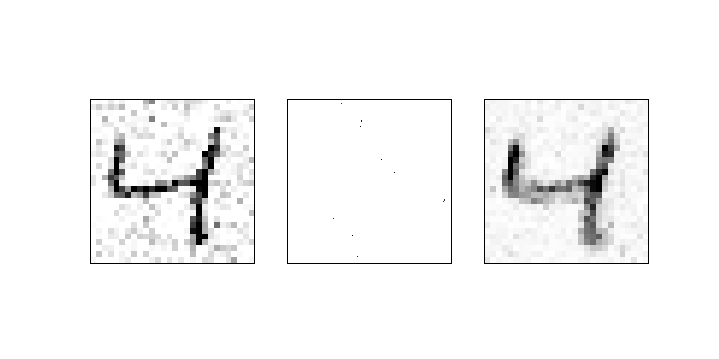

<IPython.core.display.Javascript object>


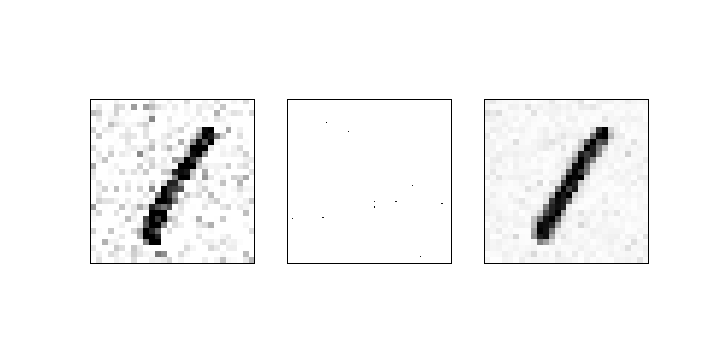

<IPython.core.display.Javascript object>


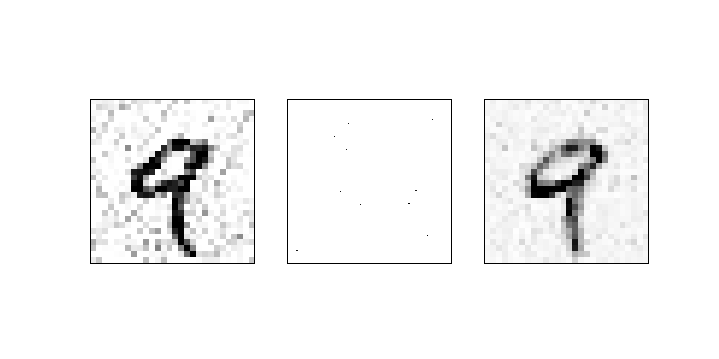

<IPython.core.display.Javascript object>


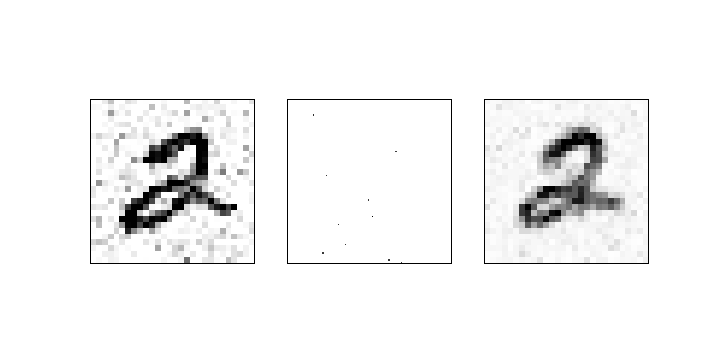

<IPython.core.display.Javascript object>


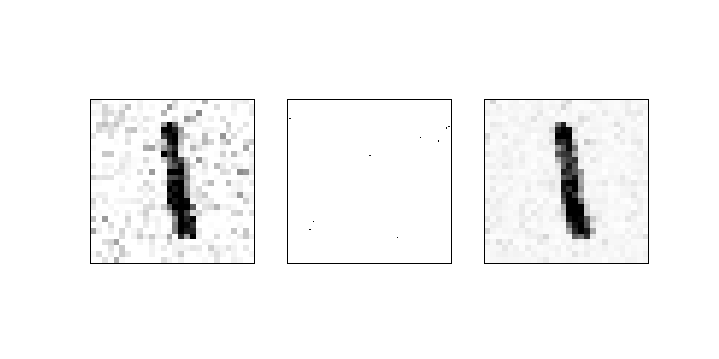

<IPython.core.display.Javascript object>


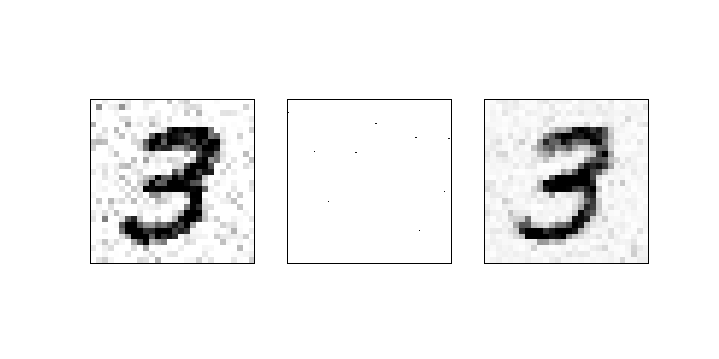

<IPython.core.display.Javascript object>


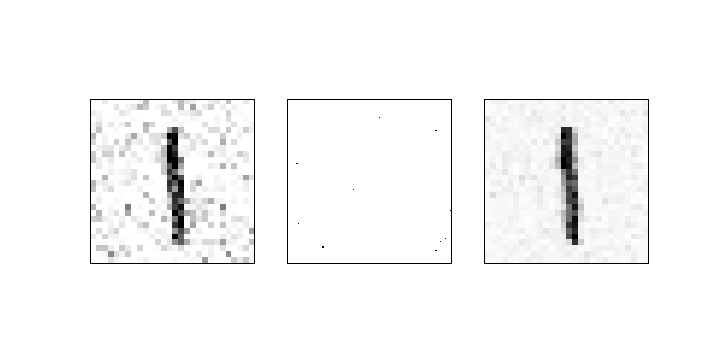

<IPython.core.display.Javascript object>


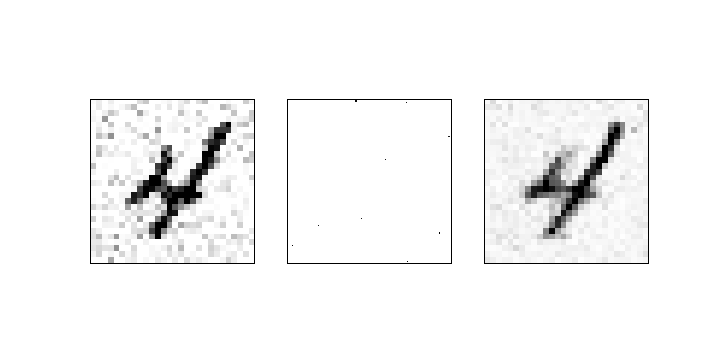

In [22]:
offset = 0

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise, 1, 0)

Yup, this is almost too dope for words.  I'm going to try two other noise profiles, then I'm done.aa

In [23]:
m_noise10 = np.clip(m_flat_tr + np.random.normal(-0.5, 0.5, m_flat_tr.shape), 0, 1)
gp_noise10 = cp.asarray(m_noise10)

<IPython.core.display.Javascript object>


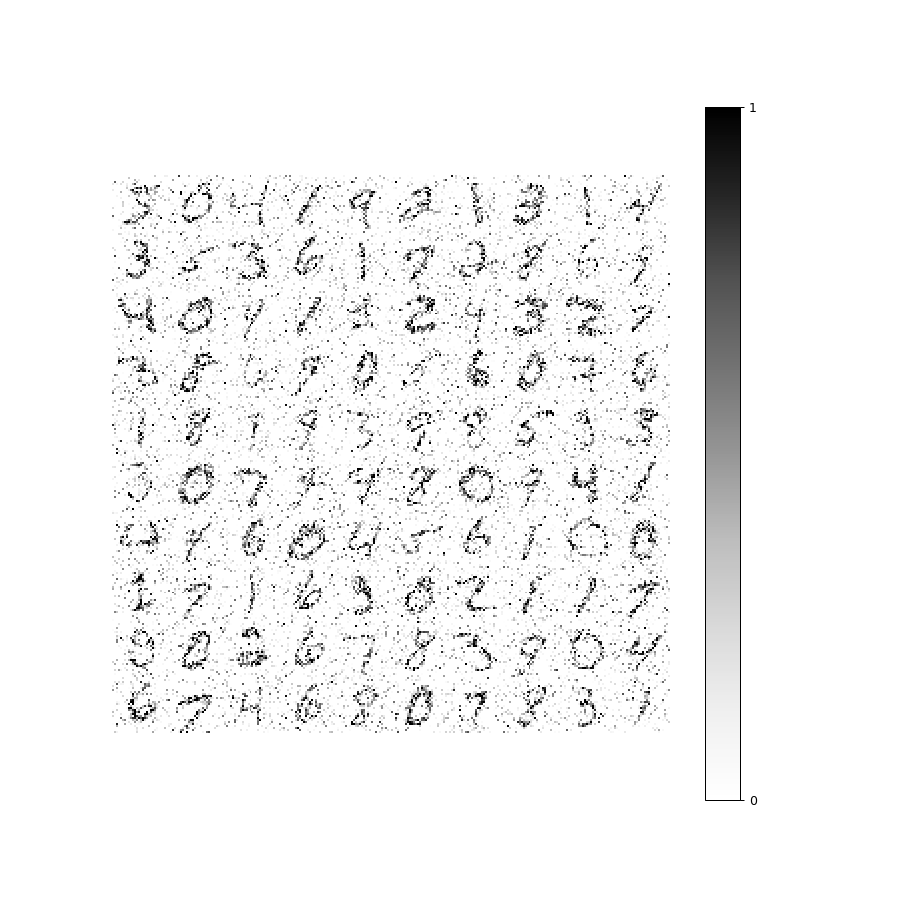

In [24]:
fig = plt.figure(figsize=(10, 10))

draw_weights(gp_noise10.get(), 10, 10, 28, fig)

<IPython.core.display.Javascript object>


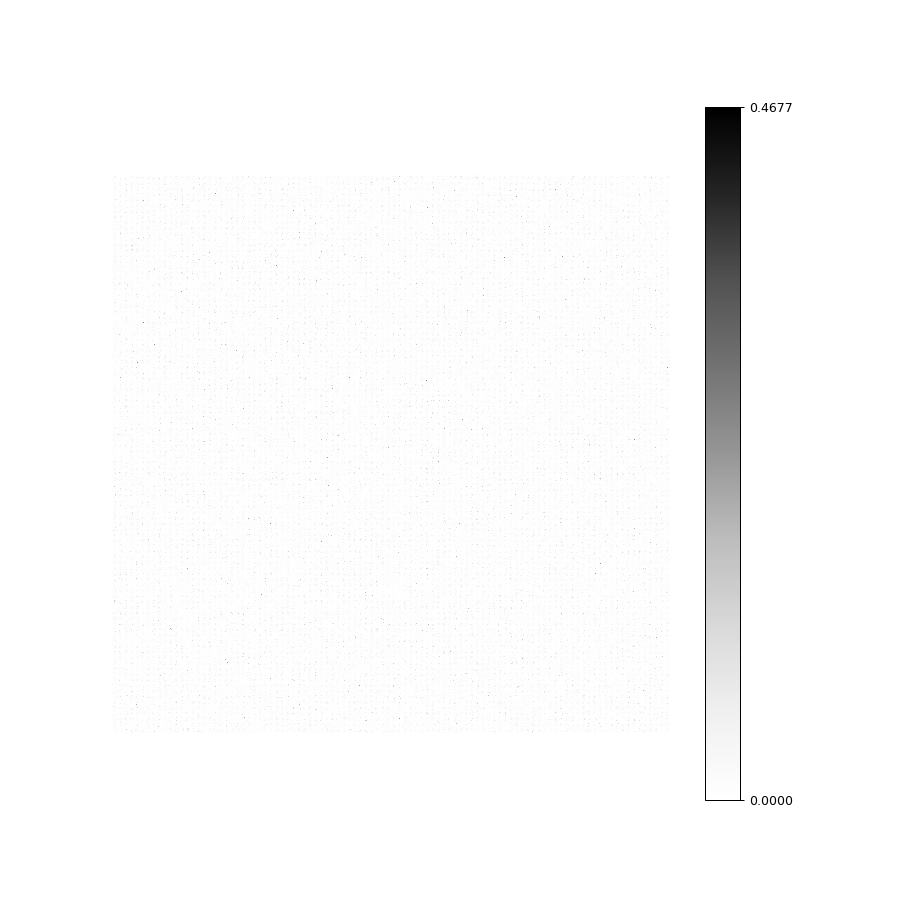

100%|██████████| 12000/12000 [00:16<00:00, 728.69it/s]


In [29]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 12000

Kx = 100
Ky = 100
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 0.2, (N, m_len))
xi = 0.02

for ep in range(Nep):
    inputs = gp_noise10[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


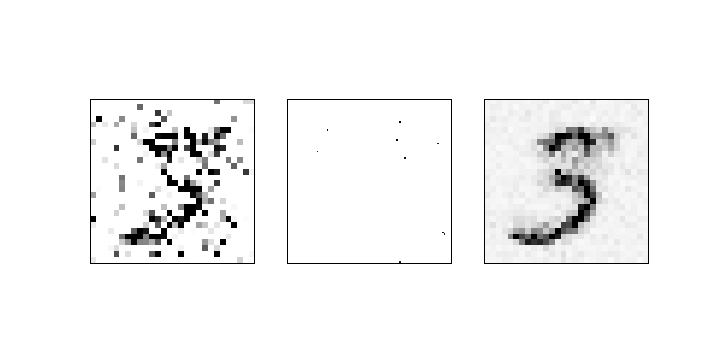

<IPython.core.display.Javascript object>


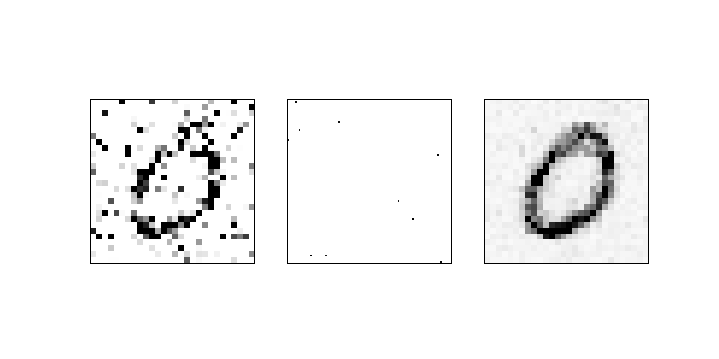

<IPython.core.display.Javascript object>


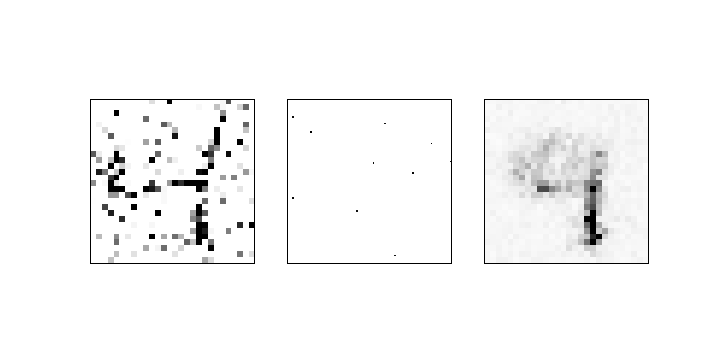

<IPython.core.display.Javascript object>


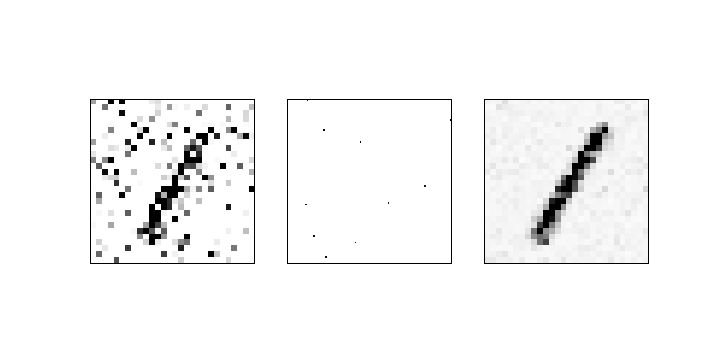

<IPython.core.display.Javascript object>


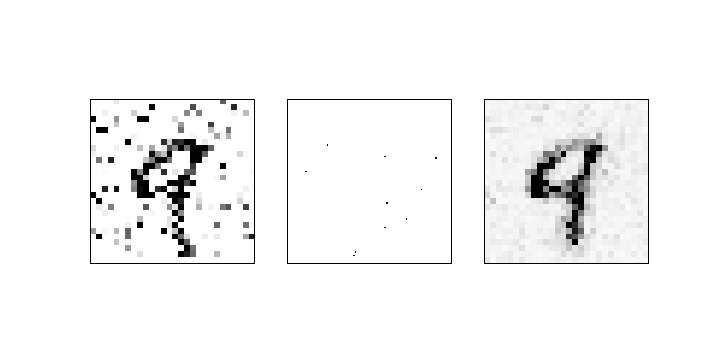

<IPython.core.display.Javascript object>


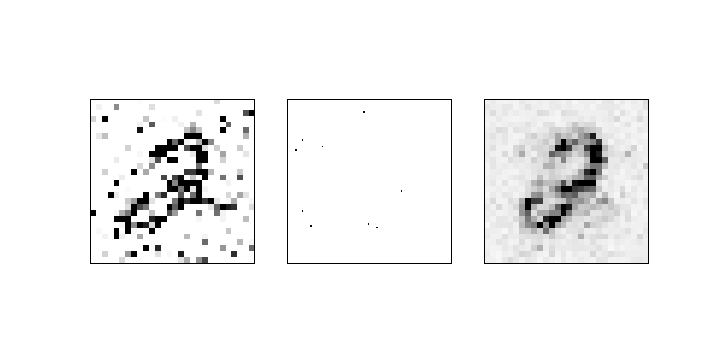

<IPython.core.display.Javascript object>


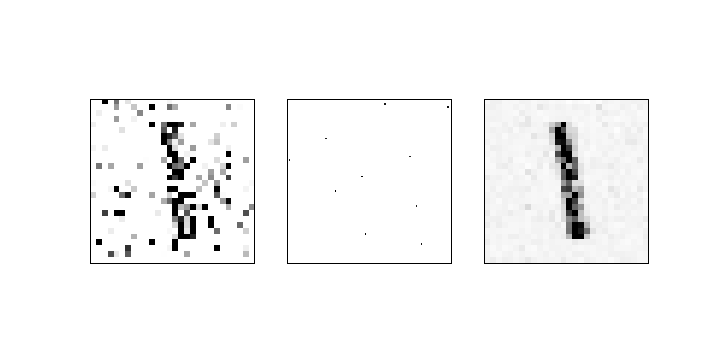

<IPython.core.display.Javascript object>


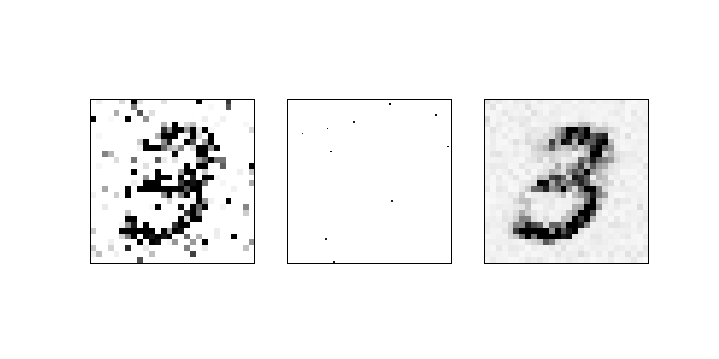

<IPython.core.display.Javascript object>


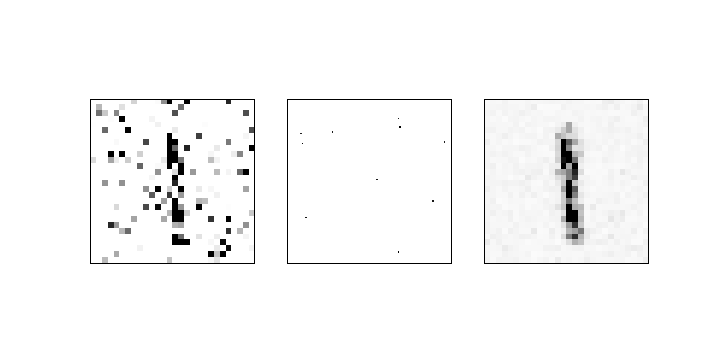

<IPython.core.display.Javascript object>


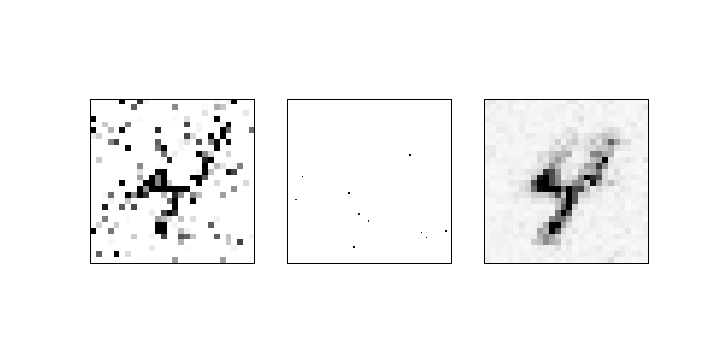

In [32]:
offset = 0

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise10, 0.5, 0)

Ok, this is dope.

## Conclusions

AWS has done it again.  The final step in this process is to shut the instance down and make sure it comes back alright.

Really the only conclusion is that AWS is dope.  I'm a huge fan of getting my hands on $5,000-$10,000 computers that make my algos super fast.

## Next steps

Take a wild guess.  The invariant layer.  No frikin way, right?  

Man I love AWS so very much.a


